In [1]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(lme4)
library(lmerTest)
library(ggeffects)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




First, lets define some priors for the AI players using Beta distributions. We'll use two separate priors-one for proposing, another for accepting. Here are prior distributions of offers made by AI players A, B, and C, where A is a "stingy" player, B is a "fair" player, and C is a "generous" player:

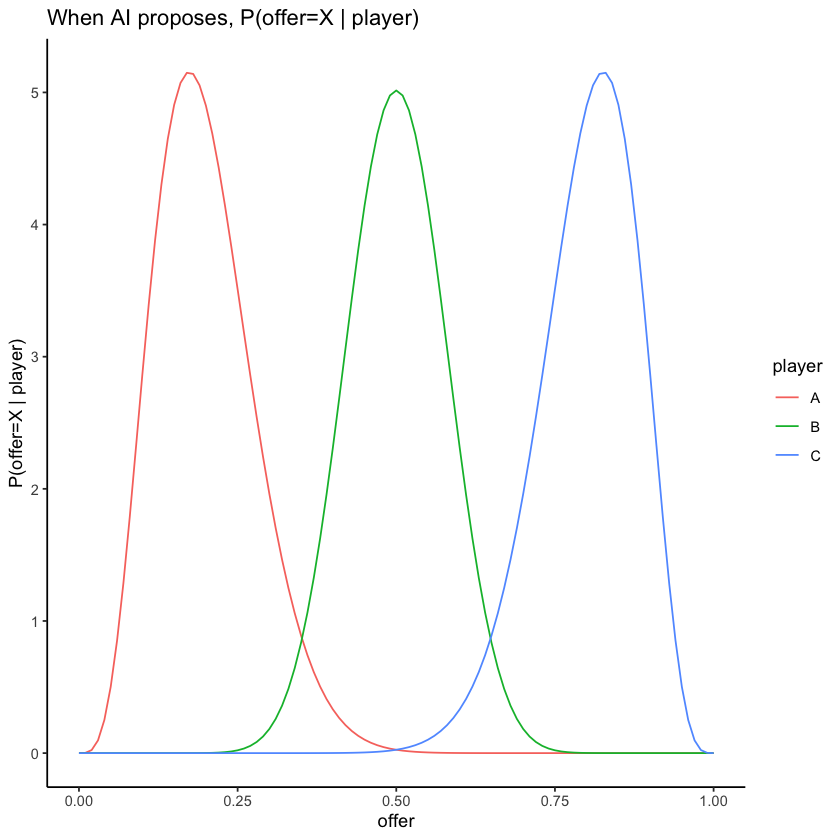

In [2]:
priors.ai <- data.frame(player=c('A', 'B', 'C'),
                        offer.s1=c(5, 20, 20),
                        offer.s2=c(20, 20, 5),
                        accept.s1=c(20, 20, 5),
                        accept.s2=c(5, 20, 20))
priors.ai %>% crossing(offer=seq(from=0, to=1, by=0.01)) %>%
    mutate(poffer=dbeta(offer, offer.s1, offer.s2)) %>%
    ggplot(aes(x=offer, y=poffer, color=player)) +
    geom_line() + theme_classic() + ylab('P(offer=X | player)') +
    ggtitle('When AI proposes, P(offer=X | player)')

Now, here are prior probabilities of the same players accepting a given offer. Again, players A, B, and C are stingy, fair, and generous. Here, instead of using the Beta distributions themselves, we're using the CDFs of the Beta distributions to get sigmoid-like curves.

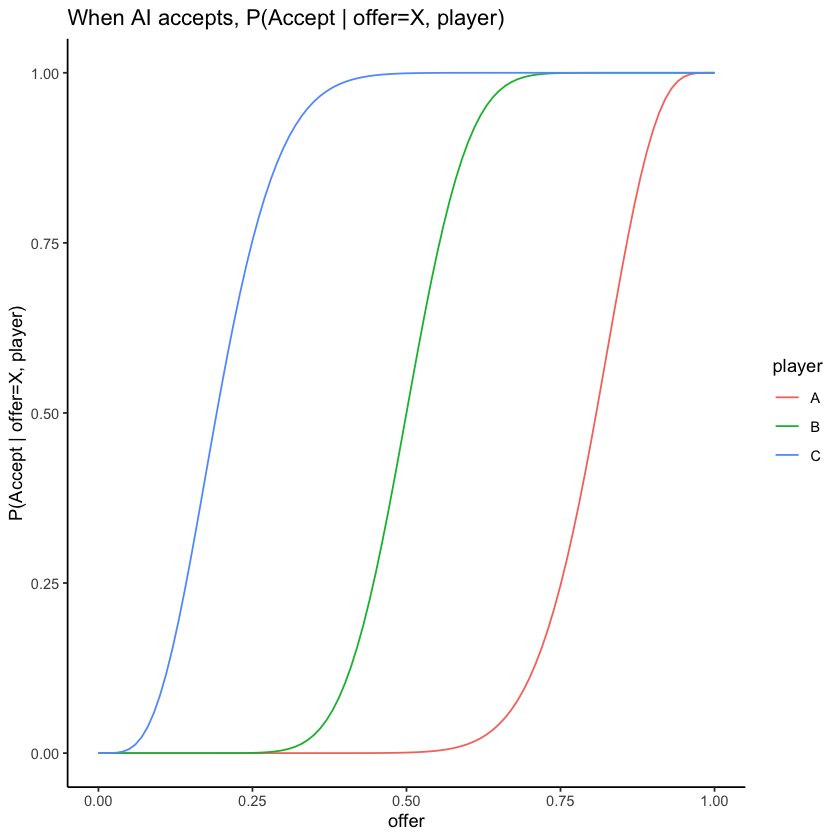

In [3]:
priors.ai %>% crossing(offer=seq(from=0, to=1, by=0.01)) %>%
    mutate(paccept=pbeta(offer, accept.s1, accept.s2)) %>%
    ggplot(aes(x=offer, y=paccept, color=player)) +
    geom_line() + theme_classic() +
    ylab('P(Accept | offer=X, player)') +
    ggtitle('When AI accepts, P(Accept | offer=X, player)')

Now, let's define similar priors for a large set of participants, some of which are assigned to propose
offers to the AI players, and others are assigned to accept offers from the AI players. Instead of using
a fixed prior for all players, we sample prior parameters using normal hyperpriors.

Sadly, I don't yet know how participants are likely to respond, so here let's pretend that they will
behave similarly to each AI player. In reality, however, participants are likely to be more variable,
accepting poor offers from stingy players while rejecting poor offers from generous players, and giving
stingy offers to exploitable players while giving more generous offers to hardball players.

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”


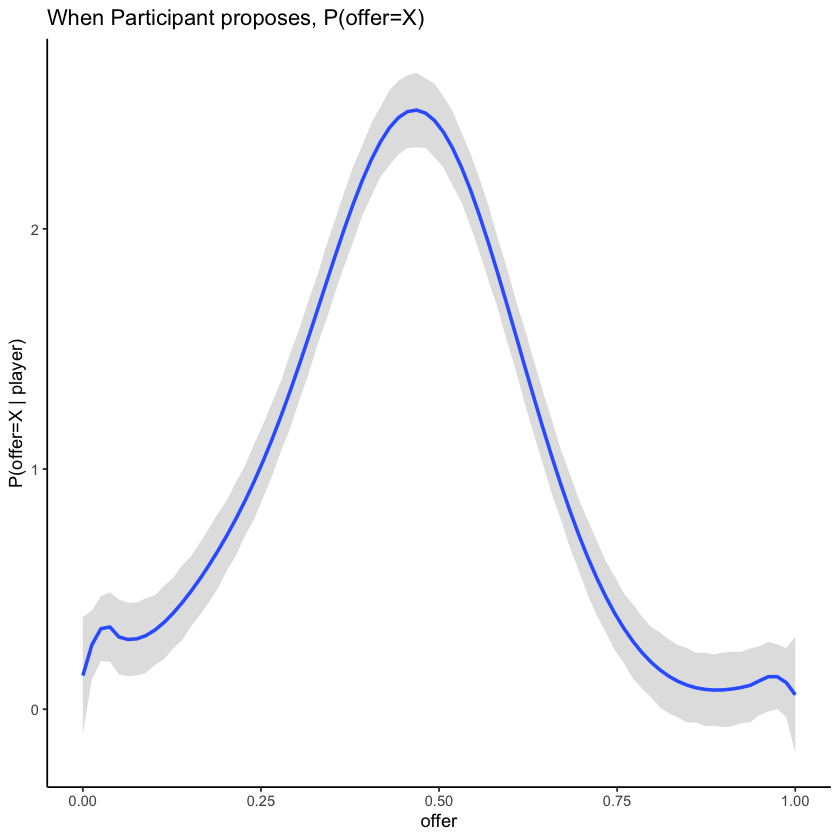

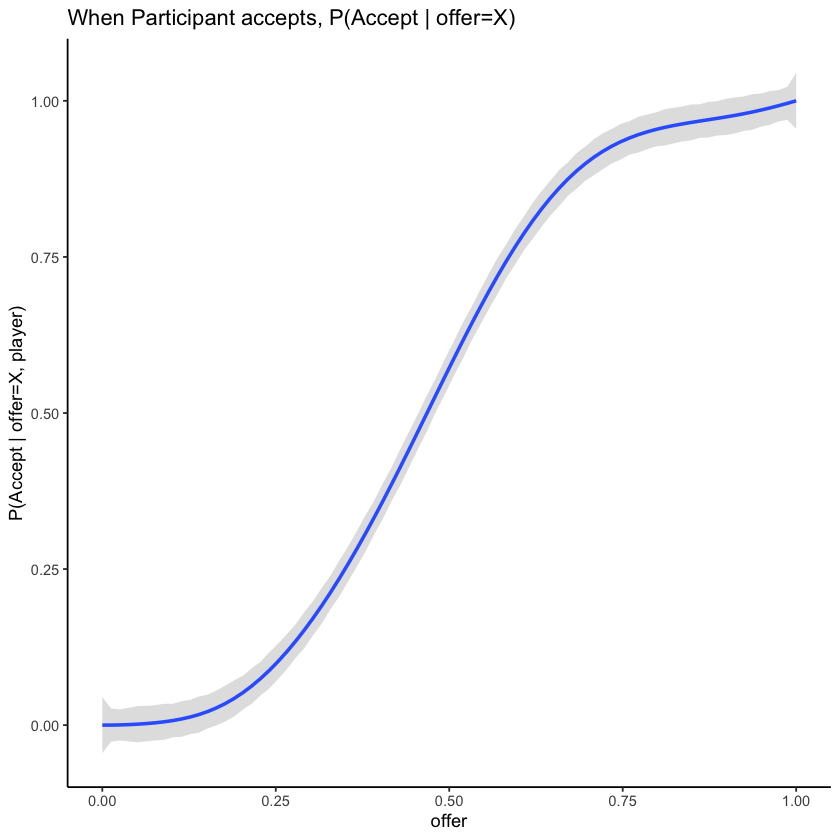

In [4]:
N <- 100  # number of participants
priors.subj <- data.frame(id=1:N,
                          condition=rep(c('propose', 'accept'), each=N/2),
                          subj.s1=rnorm(N, mean=10, sd=3),
                          subj.s2=rnorm(N, mean=10, sd=3))

priors.subj %>% filter(condition == 'propose') %>%
    crossing(offer=seq(from=0, to=1, by=0.01)) %>%
    mutate(poffer=dbeta(offer, subj.s1, subj.s2)) %>%
    ggplot(aes(x=offer, y=poffer)) +
    stat_smooth(method="loess", span=0.1, se=TRUE, alpha=0.3) + theme_classic() +
    ylab('P(offer=X | player)') +
    ggtitle('When Participant proposes, P(offer=X)')

priors.subj %>% filter(condition == 'accept') %>%
    crossing(offer=seq(from=0, to=1, by=0.01)) %>%
    mutate(paccept=pbeta(offer, subj.s1, subj.s2)) %>%
    ggplot(aes(x=offer, y=paccept)) + 
    stat_smooth(method="loess", span=0.1, se=TRUE, alpha=0.3) + theme_classic() +
    ylab('P(Accept | offer=X, player)') +
    ggtitle('When Participant accepts, P(Accept | offer=X)')

Now, using these priors, we can simulate trial data for each participant and AI player. Offers are drawn using draws from the Beta priors of the human/AI proposer, and acceptances/rejections are drawn using
a binomial distribution with a rate of acceptance defined by the human/AI Beta CDF priors.

In [5]:
TRIALS <- 25 # number of trials per subj/AI
df <- priors.subj %>% crossing(priors.ai) %>%
    mutate(ai.s1=ifelse(condition == 'propose', accept.s1, offer.s1),
           ai.s2=ifelse(condition == 'propose', accept.s2, offer.s2)) %>%
    select(-offer.s1, -offer.s2, -accept.s1, -accept.s2) %>%
    crossing(trial=1:TRIALS) %>%
    rowwise %>%
    mutate(offer=ifelse(condition=='propose',
                        rbeta(1, subj.s1, subj.s2),
                        rbeta(1, ai.s1, ai.s2)),
           accept=ifelse(condition=='propose',
                         rbinom(1, 1, pbeta(offer, ai.s1, ai.s2)),
                         rbinom(1, 1, pbeta(offer, subj.s1, subj.s2))),
           earning=ifelse(accept, offer, 0))

Finally, let's try to recover this information using a mixed-effects model:

In [ ]:
m <- glmer(accept ~ player * offer * condition + (1 | id),
           family=binomial(link='logit'),
           data=df)
m %>% ggpredict(terms=c('offer [all]', 'player', 'condition')) %>% plot()